<a href="https://colab.research.google.com/github/ABD-01/MNIST/blob/main/Triplet%20Loss/TRIPLET_LOSS_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from itertools import combinations 
 
import tensorflow as tf
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
import torchvision
import torchvision.transforms as transforms

In [2]:
!pip install torchviz

In [3]:
!pip install git+https://github.com/waleedka/hiddenlayer.git

  Cloning https://github.com/waleedka/hiddenlayer.git to /tmp/pip-req-build-u57yrjbt
  Running command git clone -q https://github.com/waleedka/hiddenlayer.git /tmp/pip-req-build-u57yrjbt
  Created wheel for hiddenlayer: filename=hiddenlayer-0.2-cp36-none-any.whl size=19771 sha256=6e01bab79bc94eb56fc34a649ae7e01fe86666505c3380f90b53a2168539d3f8
  Stored in directory: /tmp/pip-ephem-wheel-cache-9cfvpdmg/wheels/49/bc/d1/938073704abdd049b3e4cdc6811c8f468d69fb5eecc6e01748
Successfully built hiddenlayer


In [4]:
# plt.rcParams['figure.figsize'] = (5, 5)

### Triplet Loss

In [5]:
def triplet_loss(anchor, positive, negative, margin=0.2):
    pos_dist = (anchor - positive).pow(2).sum(-1) #.pow(.5)
    neg_dist = (anchor - negative).pow(2).sum(-1) #.pow(.5)
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()
 
# ref: https://github.com/adambielski/siamese-triplet/blob/master/losses.py#L24

In [6]:
def tf_triplet_loss(anchor, positive, negative, margin=0.2):  
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    loss = tf.maximum(pos_dist - neg_dist + margin, 0)
    return tf.reduce_mean(loss)
 
# ref : https://stackoverflow.com/questions/38260113/implementing-contrastive-loss-and-triplet-loss-in-tensorflow/38270293#38270293

In [7]:
torch_triplet_loss = nn.TripletMarginLoss(margin=0.2)

In [8]:
def get_triplets(embeddings:list, targets:list) -> list:
    '''
    Parameters
    ----------
    embeddings : list of torch.tensor
    targets    : list of ints

    Returns
    -------
    triplets   : list of tuple
    '''

    # eg : no(targets) = 3
    # eg : no(embeds) = 10

    assert len(embeddings) == len(targets) , "Embeddings and Targets must have same lenght"

    triplets = []
    for i, anchor in enumerate(embeddings):

        positive_pairs = list(combinations(anchor,2))  # this will give of distinct pairs of elements 
                                                                 # no(pos_pairs) = no(targets)P2 / 2!  # eg : 45
        
        temp = embeddings.pop(i)  # embeddings list except the anchor
        for negative_embeddings in torch.cat(embeddings,dim=0):   # loops runs for no(targets)-1 * no(embeds) times  # eg : (3-1)*10=20 
            
            triple = [(positive_pair[0], positive_pair[1], negative_embeddings) for positive_pair in positive_pairs]  # no(triple) = n(pos_pair) # eg: 45
            
            triplets.extend(triple)   # no. of triplets added = no(pos_pairs)*(no(targets) - 1)*(no(embeds))  # eg: 45*2*10=900

        embeddings.insert(i, temp)

    return triplets  # no(triplets) = no(added_triples) * no(embeds) # eg: 900*3 = 2700

# ref : A lot can't even even mention here

In [9]:
def get_tensor_triplets(embeddings:list, targets:list) -> list:
    '''
    Parameters
    ----------
    embeddings : list of torch.tensor each of shape torch.Size([?, 128])
    targets    : list of ints

    Returns
    -------
    triplets   : torch.tensor of shape torch.Size([?, no(triplets), 3])
    '''

    # eg : no(targets) = 3
    # eg : no(embeds) = 10

    assert len(embeddings) == len(targets) , "Embeddings and Targets must have same lenght"

    triplets = []
    for i, anchor in enumerate(embeddings):

        positive_pairs = list(combinations(anchor,2))  # this will give of distinct pairs of elements 
                                                                 # no(pos_pairs) = no(targets)P2 / 2!  # eg : 45
        
        temp = embeddings.pop(i)  # embeddings list except the anchor
        for negative_embeddings in torch.cat(embeddings,dim=0):   # loops runs for no(targets)-1 * no(embeds) times  # eg : (3-1)*10=20 
            
            triple = [torch.stack([positive_pair[0], positive_pair[1], negative_embeddings], dim=0) for positive_pair in positive_pairs]  # no(triple) = n(pos_pair) # eg: 45
            
            triplets.extend(triple)   # no. of triplets added = no(pos_pairs)*(no(targets) - 1)*(no(embeds))  # eg: 45*2*10=900

        embeddings.insert(i, temp)

    return torch.stack(triplets, dim=0)  # no(triplets) = no(added_triples) * no(embeds) # eg: 900*3 = 2700

# ref : A lot can't even even mention here

In [10]:
MNIST_train = torchvision.datasets.MNIST(
    root = '/content/drive/MyDrive/Colab Notebooks/',
    download = True,
    train = True,
    transform = transforms.ToTensor()
)

In [11]:
MNIST_train.data.shape

torch.Size([60000, 28, 28])

4

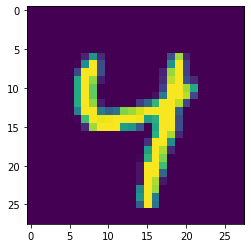

In [12]:
i =5734
plt.imshow(MNIST_train[i][0].squeeze())
MNIST_train[i][1]

## Reorganizing Data

In [13]:
train_dict = {i : MNIST_train.data[MNIST_train.targets == i].unsqueeze(1) / 255 for i in range(10)}
print(*[f'{imgs.shape[0]} images of Label {label} of shape {imgs.shape[1:]}' for label, imgs in train_dict.items()], sep='\n')
# for i in range(10):
#     train_dict[i] = MNIST_train.data[MNIST.targets == i]

5923 images of Label 0 of shape torch.Size([1, 28, 28])
6742 images of Label 1 of shape torch.Size([1, 28, 28])
5958 images of Label 2 of shape torch.Size([1, 28, 28])
6131 images of Label 3 of shape torch.Size([1, 28, 28])
5842 images of Label 4 of shape torch.Size([1, 28, 28])
5421 images of Label 5 of shape torch.Size([1, 28, 28])
5918 images of Label 6 of shape torch.Size([1, 28, 28])
6265 images of Label 7 of shape torch.Size([1, 28, 28])
5851 images of Label 8 of shape torch.Size([1, 28, 28])
5949 images of Label 9 of shape torch.Size([1, 28, 28])


In [14]:
label = 7
rand_imgs = train_dict[label][random.sample(range(1, 5000), 100)]
grid = torchvision.utils.make_grid(rand_imgs, nrow=10, pad_value=20)
# ref: https://pytorch.org/vision/stable/utils.html#torchvision-utils

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


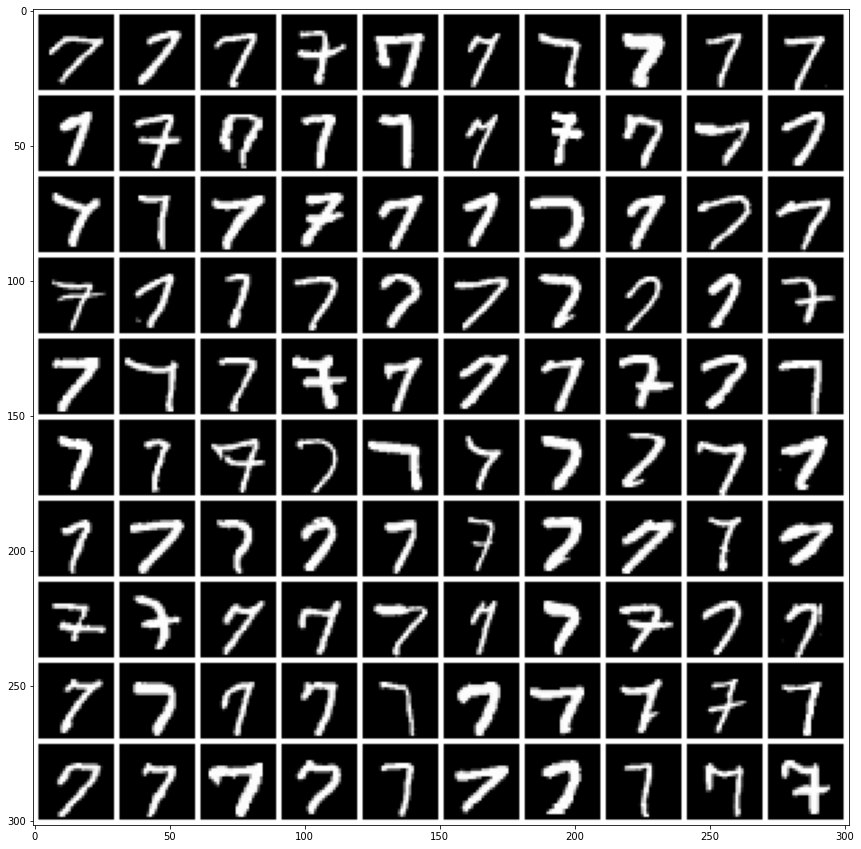

In [15]:
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))

Image Processing 

In [16]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Normalize(mean=0.1307, std=0.3081),
    transforms.Lambda(lambda image: torch.cat((image,image,image), dim=-3)),
])
# ref: https://pytorch.org/hub/pytorch_vision_resnet/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


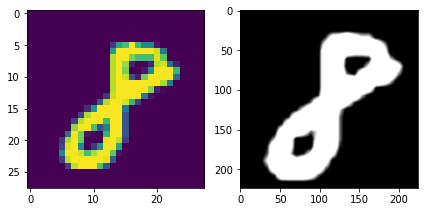

In [17]:
timg = train_dict[8][1]  # shape = (1,28,28)
ptimg = preprocess(timg)  # shape = (3,224,224)

_, axarr = plt.subplots(1,2, figsize = (7,7)) 

axarr[0].imshow(timg.squeeze())

axarr[1].imshow(torch.movedim(ptimg, -3, -1))
#ref : https://pytorch.org/docs/stable/generated/torch.movedim.html

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


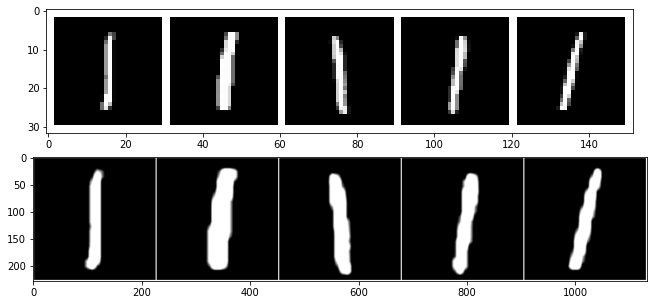

In [18]:
rand_imgs = train_dict[1][random.sample(range(1, 5000), 5)]  # shape = (5,1,28,28)
grid = torchvision.utils.make_grid(rand_imgs, nrow=5, pad_value=20)

prand_imgs = preprocess(rand_imgs)  # shape = (5,3,224,224)
pgrid = torchvision.utils.make_grid(prand_imgs, nrow=5, pad_value=20)

fig , axarr = plt.subplots(2,1, figsize = (15,5)) 

axarr[0].imshow(np.transpose(grid, (1,2,0)))
axarr[1].imshow(np.transpose(pgrid, (1,2,0)))

# Creating Model

In [19]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.preprocess = transforms.Compose([
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                            transforms.Normalize(mean=0.1307, std=0.3081),
                            transforms.Lambda(lambda image: torch.cat((image,image,image), dim=-3)),
                        ])
        # ref: https://pytorch.org/hub/pytorch_vision_resnet/

        self.resnet18 = torchvision.models.resnet18(pretrained=False)
        self.out = nn.Linear(in_features=1000, out_features=128)

    def forward(self, images):
        images = self.preprocess(images)
        images = self.resnet18(images)
        encodings = self.out(images)

        return encodings


In [20]:
model = Model()
model

Model(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

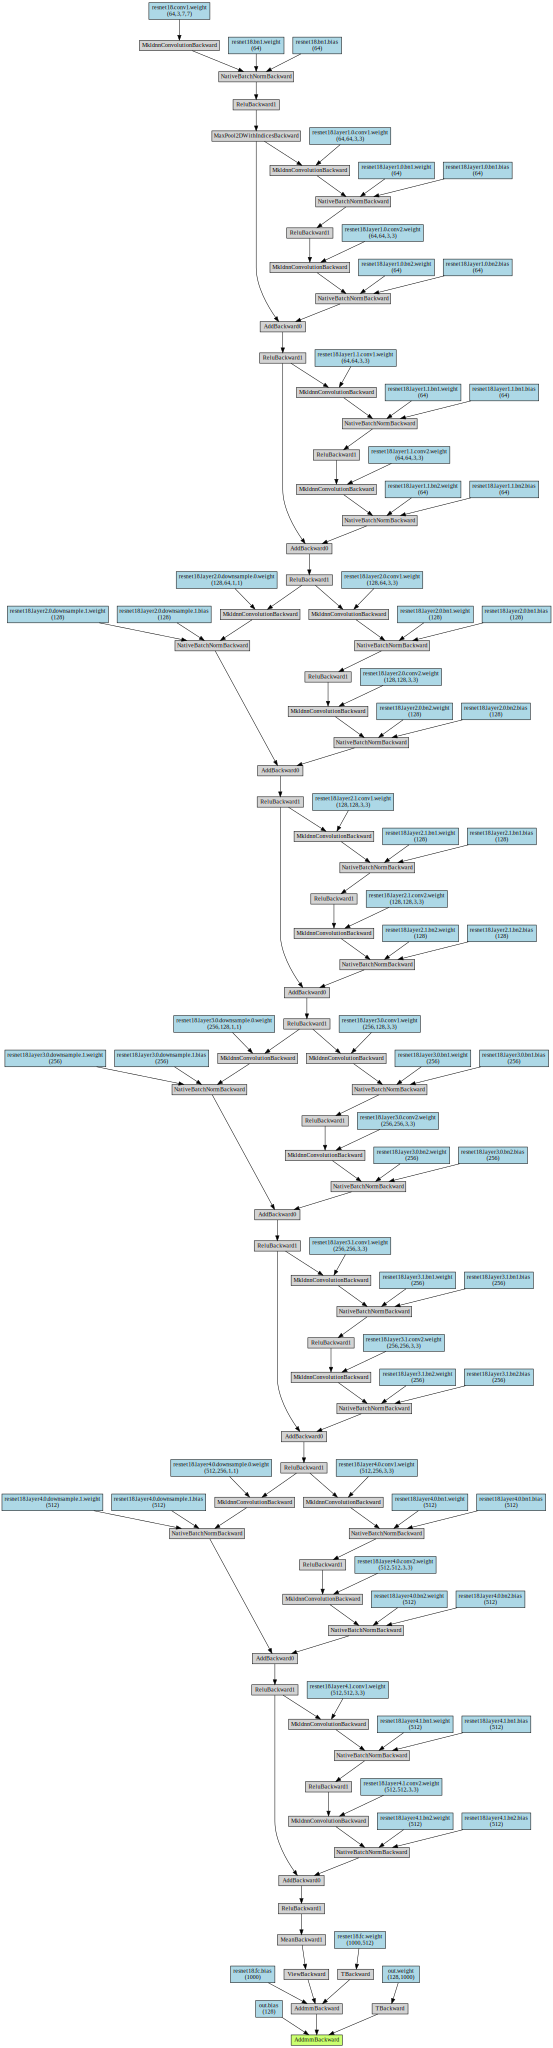

In [21]:
from torchviz import make_dot

x = torch.randn(10,1,28,28)

make_dot(model(x), params=dict(model.named_parameters()))   

# ref : https://github.com/szagoruyko/pytorchviz/blob/master/examples.ipynb

/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_helper.py:267: UserWarning: You are trying to export the model with onnx:Upsample for ONNX opset version 9. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator. 
  "" + str(_export_onnx_opset_version) + ". "
/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


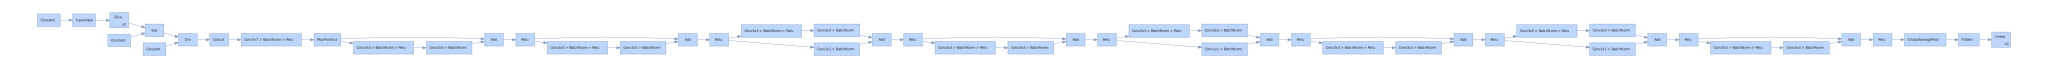

In [22]:
import hiddenlayer as hl

# Build HiddenLayer graph
hl_graph = hl.build_graph(model, torch.zeros([1, 1, 28, 28]))

# Use a different color theme
hl_graph.theme = hl.graph.THEMES["blue"].copy()  # Two options: basic and blue
hl_graph

#ref : https://github.com/waleedka/hiddenlayer/blob/master/demos/pytorch_graph.ipynb

In [23]:
# Passing only 10 images of class 0,1,2 each.

encoding_dict = {}
for i in range(5):
    encoding_dict[i] = model(train_dict[i][:10]) #.detach().numpy()

In [24]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
 
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(3):
        plt.scatter(embeddings[i].detach().numpy()[:,:64],embeddings[i].detach().numpy()[:,64:], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(targets)

# ref: https://github.com/adambielski/siamese-triplet/blob/master/Experiments_MNIST.ipynb

In [25]:
[encoding_dict[0], encoding_dict[1], encoding_dict[2]][0].shape

torch.Size([10, 128])

In [26]:
triplets = get_triplets(embeddings=[encoding_dict[0], encoding_dict[1], encoding_dict[2]], targets=[0,1,2])

In [27]:
type(triplets)

list

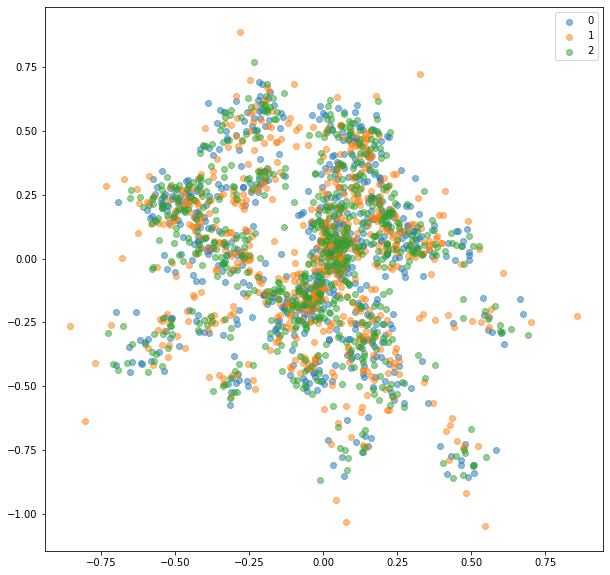

In [28]:
plot_embeddings([encoding_dict[0], encoding_dict[1], encoding_dict[2]], [0,1,2])

## Running the Model

In [29]:
zeros_images = train_dict[0][:10]
ones_images  = train_dict[1][:10]
twos_images  = train_dict[2][:10]

In [30]:
model = Model()

learning_rate = 0.001
lossfn = triplet_loss
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


In [55]:
cost = []

epochs = 12
for epoch in range(epochs):
    zeros_encodings = model(zeros_images)
    ones_encodings = model(ones_images)
    twos_encodings = model(twos_images)

    triplets = get_tensor_triplets([zeros_encodings, ones_encodings, twos_encodings], [0, 1, 2])

    anchor   = triplets[:,0]
    positive = triplets[:,1]
    negative = triplets[:,2]
    # anchor = torch.stack([triple[0] for triple in triplets])
    # positive = torch.stack([triple[1] for triple in triplets])
    # negative = torch.stack([triple[2] for triple in triplets])

    optimizer.zero_grad()
    loss = lossfn(anchor, positive, negative, margin=5)
    cost.append(loss)

    
    loss.backward(retain_graph=True)
    optimizer.step()

    print(f'Epoch:[{epoch+1}/{epochs}] , Cost : {loss.item()}')


Epoch:[1/12] , Cost : 0.036221470683813095
Epoch:[2/12] , Cost : 0.0140049047768116
Epoch:[3/12] , Cost : 0.004975256510078907
Epoch:[4/12] , Cost : 0.009303901344537735
Epoch:[5/12] , Cost : 0.014167539775371552
Epoch:[6/12] , Cost : 0.000251527177169919
Epoch:[7/12] , Cost : 0.0
Epoch:[8/12] , Cost : 0.0003095473221037537
Epoch:[9/12] , Cost : 0.00040924461791291833
Epoch:[10/12] , Cost : 0.0
Epoch:[11/12] , Cost : 0.0
Epoch:[12/12] , Cost : 0.0


In [32]:
triplets[:,1].shape

torch.Size([2700, 128])

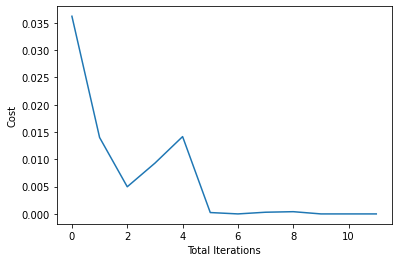

In [56]:
plt.xlabel('Total Iterations')
plt.ylabel('Cost')
plt.plot(np.arange(epochs), cost)
plt.show()

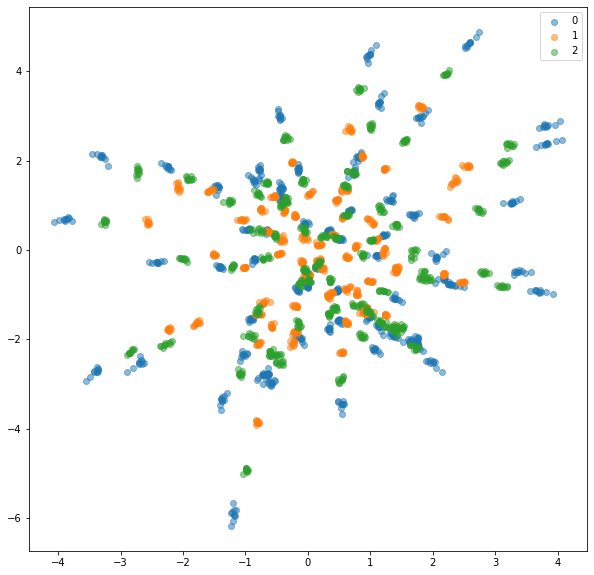

In [57]:
plot_embeddings([zeros_encodings, ones_encodings, twos_encodings], [0,1,2])

In [35]:
(zeros_encodings - ones_encodings).pow(2).sum(-1)

tensor([ 87.8144,  74.9815,  57.2611,  58.6250,  78.1003,  71.5962,  74.1449,
        120.8613,  59.6685,  65.3264], grad_fn=<SumBackward1>)

In [36]:
(zeros_encodings - twos_encodings).pow(2).sum(-1)

tensor([15.6241, 12.9641,  8.0041,  7.8231, 10.6257, 14.7286,  7.3991, 28.4479,
         6.6842, 13.9762], grad_fn=<SumBackward1>)

In [37]:
(zeros_encodings - zeros_encodings).pow(2).sum(-1)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SumBackward1>)

In [38]:
(ones_encodings - twos_encodings).pow(2).sum(-1)

tensor([29.5365, 25.8645, 22.9631, 23.9303, 31.4965, 21.6588, 35.3426, 32.5045,
        26.7337, 19.1701], grad_fn=<SumBackward1>)

In [39]:
(anchor - positive).pow(2).sum(-1)

tensor([0.0978, 1.5033, 0.9423,  ..., 0.1879, 0.9891, 0.9193],
       grad_fn=<SumBackward1>)

In [40]:
(anchor - negative).pow(2).sum(-1)

tensor([87.8144, 87.8144, 87.8144,  ..., 27.4196, 27.4196, 26.8464],
       grad_fn=<SumBackward1>)

In [41]:
triplets = get_triplets([zeros_encodings, ones_encodings, twos_encodings], [0, 1, 2])

anchor = torch.stack([triple[0] for triple in triplets])
positive = torch.stack([triple[1] for triple in triplets])
negative = torch.stack([triple[2] for triple in triplets])

In [42]:
triplet_loss(anchor, positive, negative)

tensor(0.0054, grad_fn=<MeanBackward0>)

In [43]:
anchor.shape

torch.Size([2700, 128])

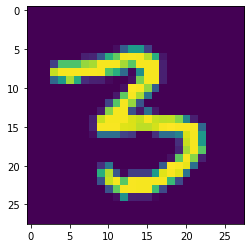

In [90]:
plt.imshow(train_dict[3][42].squeeze())

In [91]:
test_emb = model(train_dict[3][42].unsqueeze(0))
test_emb1 = model(train_dict[3][47].unsqueeze(0))

In [93]:
(test_emb - ones_encodings[0]).pow(2).sum(-1)

tensor([41.0552], grad_fn=<SumBackward1>)

In [94]:
(test_emb - twos_encodings[0]).pow(2).sum(-1)

tensor([5.6076], grad_fn=<SumBackward1>)

In [95]:
(test_emb - zeros_encodings[0]).pow(2).sum(-1)

tensor([1.8835], grad_fn=<SumBackward1>)

In [96]:
(test_emb - test_emb1).pow(2).sum(-1)

tensor([0.7510], grad_fn=<SumBackward1>)

In [49]:
zeros_encodings[0].shape

torch.Size([128])

## Random Testings

In [50]:
a = torch.rand(5,3,4)*10
print(a.shape)
a

torch.Size([5, 3, 4])


tensor([[[0.9145, 9.0554, 3.0941, 4.3454],
         [5.1647, 2.7669, 1.2951, 9.4477],
         [4.3496, 8.4010, 1.8456, 2.1345]],

        [[7.9413, 6.7599, 0.5749, 2.9436],
         [8.1335, 3.0668, 7.0523, 9.4117],
         [9.5833, 3.4734, 1.7836, 6.2784]],

        [[7.2848, 9.3394, 7.7352, 1.5623],
         [4.9603, 9.2855, 6.9456, 7.2125],
         [9.0303, 2.9819, 8.9612, 5.7516]],

        [[8.0295, 7.1429, 4.4527, 2.6792],
         [3.6924, 2.6098, 8.0481, 3.7757],
         [4.3607, 6.3759, 0.8102, 6.2810]],

        [[2.7548, 1.6226, 3.8099, 4.5049],
         [6.4192, 6.0484, 1.4228, 9.5073],
         [0.7468, 3.2883, 6.1046, 8.1649]]])

In [51]:
a = torch.rand(2,5)
p = torch.rand(2,5)
n = torch.rand(2,5)
a,p,n

(tensor([[0.9563, 0.7067, 0.6240, 0.6579, 0.3391],
         [0.3969, 0.5493, 0.6216, 0.5138, 0.4617]]),
 tensor([[0.5854, 0.9637, 0.6307, 0.3318, 0.1295],
         [0.8353, 0.8691, 0.6360, 0.6851, 0.7002]]),
 tensor([[0.4751, 0.2497, 0.4833, 0.1272, 0.8322],
         [0.8466, 0.4413, 0.7155, 0.2002, 0.3106]]))

In [52]:
t = get_triplets([a,p,n], [0,1,2])
len(t)
# type(t[2699])
# len(t[2699][0])
# type(t[2699][0])
for _ in t: print(_, end="\n\n")

(tensor([0.9563, 0.7067, 0.6240, 0.6579, 0.3391]), tensor([0.3969, 0.5493, 0.6216, 0.5138, 0.4617]), tensor([0.5854, 0.9637, 0.6307, 0.3318, 0.1295]))

(tensor([0.9563, 0.7067, 0.6240, 0.6579, 0.3391]), tensor([0.3969, 0.5493, 0.6216, 0.5138, 0.4617]), tensor([0.8353, 0.8691, 0.6360, 0.6851, 0.7002]))

(tensor([0.9563, 0.7067, 0.6240, 0.6579, 0.3391]), tensor([0.3969, 0.5493, 0.6216, 0.5138, 0.4617]), tensor([0.4751, 0.2497, 0.4833, 0.1272, 0.8322]))

(tensor([0.9563, 0.7067, 0.6240, 0.6579, 0.3391]), tensor([0.3969, 0.5493, 0.6216, 0.5138, 0.4617]), tensor([0.8466, 0.4413, 0.7155, 0.2002, 0.3106]))

(tensor([0.5854, 0.9637, 0.6307, 0.3318, 0.1295]), tensor([0.8353, 0.8691, 0.6360, 0.6851, 0.7002]), tensor([0.9563, 0.7067, 0.6240, 0.6579, 0.3391]))

(tensor([0.5854, 0.9637, 0.6307, 0.3318, 0.1295]), tensor([0.8353, 0.8691, 0.6360, 0.6851, 0.7002]), tensor([0.3969, 0.5493, 0.6216, 0.5138, 0.4617]))

(tensor([0.5854, 0.9637, 0.6307, 0.3318, 0.1295]), tensor([0.8353, 0.8691, 0.6360, 0.685

In [53]:
tt = get_tensor_triplets([a,p,n], [0,1,2])

In [54]:
type(tt)
tt.shape
# tt[:,0].shape
tt[:,0] #.shape

tensor([[0.9563, 0.7067, 0.6240, 0.6579, 0.3391],
        [0.9563, 0.7067, 0.6240, 0.6579, 0.3391],
        [0.9563, 0.7067, 0.6240, 0.6579, 0.3391],
        [0.9563, 0.7067, 0.6240, 0.6579, 0.3391],
        [0.5854, 0.9637, 0.6307, 0.3318, 0.1295],
        [0.5854, 0.9637, 0.6307, 0.3318, 0.1295],
        [0.5854, 0.9637, 0.6307, 0.3318, 0.1295],
        [0.5854, 0.9637, 0.6307, 0.3318, 0.1295],
        [0.4751, 0.2497, 0.4833, 0.1272, 0.8322],
        [0.4751, 0.2497, 0.4833, 0.1272, 0.8322],
        [0.4751, 0.2497, 0.4833, 0.1272, 0.8322],
        [0.4751, 0.2497, 0.4833, 0.1272, 0.8322]])